In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [5]:
def plot_images(*images, titles=None, cmap='gray', height=10):
    """
    Plots an arbitrary number of images in a subplot.

    Parameters:
    *images: list of numpy.ndarray
        The images to be plotted.
    titles: list of str, optional
        Titles for each subplot. If None, no titles will be displayed.
    cmap: str, optional
        Colormap to be used for displaying the images. Default is 'gray'.
    """
    num_images = len(images)
    plt.figure(figsize=(height, 5 * num_images))

    for i, image in enumerate(images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap=cmap)
        if titles and i < len(titles):
            plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
def crop_img(img, x, y, w, h):
    return img[y:y+h, x:x+w]

In [14]:
# Load the historical map image
image = cv2.imread('data/Siegfried.tif', cv2.IMREAD_COLOR)

# Convert the image to grayscale
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Convert the image from BGR (OpenCV default) to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Split the image into R, G, B channels
R, G, B = cv2.split(image_rgb)

In [73]:
def plot_threshold(channel, thresh_channel):
    # Plot the original, each thresholded channel, and histograms
    plt.figure(figsize=(15, 8))

    # Green Channel Thresholded
    plt.subplot(3, 3, 1)
    plt.title('Input Channel')
    plt.imshow(channel, cmap='gray')

    # Red Channel Thresholded
    plt.subplot(3, 3, 2)
    plt.title('Thresholded Channel')
    plt.imshow(thresh_channel, cmap='gray')

    # Red Channel Histogram
    plt.subplot(3, 3, 3)
    plt.title('Channel Histogram')
    plt.hist(channel.ravel(), bins=256, color='black', alpha=0.7)
    plt.xlim([0, 256])

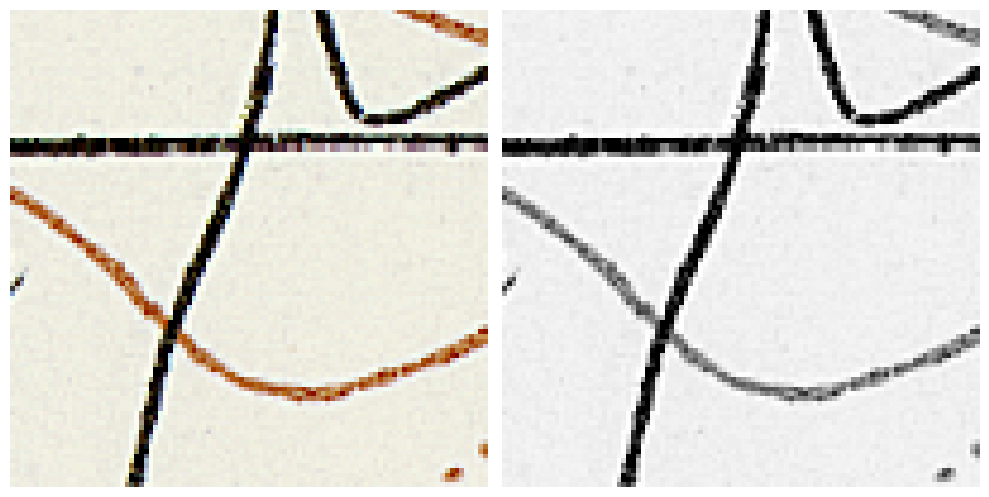

In [16]:
plot_images(cropped_image, cropped_image_gray)

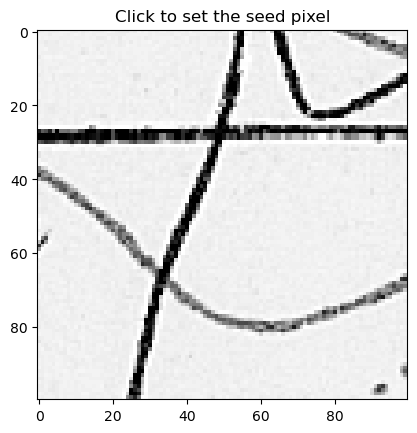

No seed point selected.


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color

def select_seed(image):
    """
    Function to display the image and allow the user to click on a point to set a seed pixel.
    
    Parameters:
    image (ndarray): Input image (can be grayscale or RGB).
    
    Returns:
    seed_point (tuple): Coordinates of the selected seed pixel (row, col).
    """
    # Convert to grayscale if it's an RGB image
    if len(image.shape) == 3:
        grayscale = color.rgb2gray(image)
    else:
        grayscale = image

    # Set up the plot
    fig, ax = plt.subplots()
    ax.imshow(grayscale, cmap='gray')
    ax.set_title('Click to set the seed pixel')

    # To store the clicked seed point
    seed_point = []

    # Event handler to capture the click event
    def onclick(event):
        # Ensure that the click is within the image bounds
        if event.xdata is not None and event.ydata is not None:
            x, y = int(event.xdata), int(event.ydata)
            seed_point.append((y, x))  # Append row, col format
            ax.plot(x, y, 'ro')  # Mark the seed point on the image
            plt.draw()  # Update the plot immediately
            print(f'Seed point selected: (row={y}, col={x})')

    # Connect the click event to the handler
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

    # Show the plot and wait for interaction
    plt.show()

    # Disconnect the event handler after the plot is closed
    fig.canvas.mpl_disconnect(cid)

    # Return the selected seed point (or None if no point is clicked)
    return seed_point[0] if seed_point else None

# Example usage
# Load the image (replace 'path_to_your_map.tiff' with your image path)
image = cropped_image

# Call the function to select the seed pixel
seed = select_seed(image)

if seed is not None:
    print(f'Seed pixel coordinates: {seed}')
else:
    print('No seed point selected.')


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, color, morphology
from skimage.segmentation import flood, flood_fill


In [105]:

# Step 4: Define the position and size of the crop
x_start = 50  # x-coordinate of the top-left corner
y_start = 300  # y-coordinate of the top-left corner
width = 100    # Width of the crop
height = 100   # Height of the crop

# Step 5: Crop the image using array slicing
cropped_image = crop_img(image_rgb, x_start, y_start, width, height)
cropped_image_gray = crop_img(image_gray, x_start, y_start, width, height)


def mask_flood_fill(image, seed=(58, 24), tolerance=0.5):
    """
    Function to perform flood fill on an image starting from a seed point.
    
    Parameters:
    image (ndarray): Input image (grayscale or RGB).
    seed (tuple): Seed point coordinates (row, col).
    tolerance (float): Tolerance value for flood fill.
    
    Returns:
    mask (ndarray): Binary mask of the flooded region.
    """
    
    img_hsv_ = color.rgb2hsv(image)
    img_hsv_copy_ = np.copy(img_hsv_)
    # flood function returns a mask of flooded pixels
    mask = flood(img_hsv_[..., 0], seed, tolerance=tolerance)
    # Set pixels of mask to new value for hue channel
    img_hsv_[mask, 0] = 0.5
    # Post-processing in order to improve the result
    # Remove white pixels from flag, using saturation channel
    mask_postprocessed_1 = np.logical_and(mask, img_hsv_copy_[..., 1] > 0.2)
    # Remove thin structures with binary opening
    mask_postprocessed_2= morphology.binary_opening(mask_postprocessed_1, np.ones((3, 3)))
    # Fill small holes with binary closing
    mask_postprocessed_3 = morphology.binary_closing(mask_postprocessed_2, morphology.disk(20))
    img_hsv_copy_[mask_postprocessed_3, 0] = 0.5
    

    # Step 6: Create a mask for only hue = 0.5
    mask_hue_05 = img_hsv_copy_[..., 0] == 0.5
    
    return img_hsv_, img_hsv_copy_, mask_hue_05





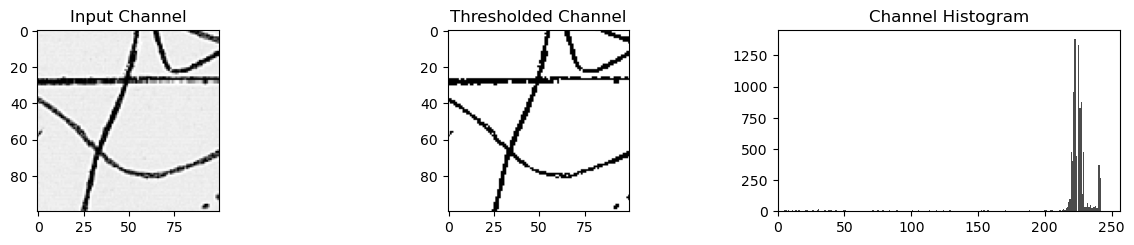

In [81]:
# Split the image into R, G, B channels
R, G, B = cv2.split(cropped_image)

# Define threshold values for each channel
threshold_R = 100  # Adjust for Red channel
threshold_G = 0  # Adjust for Green channel
threshold_B = 100  # Adjust for Blue channel
threshold_Gray = 50 # Adjust for Gray channel

# Step 1: Threshold each channel separately
_, thresh_R = cv2.threshold(R, threshold_R, 255, cv2.THRESH_BINARY)
_, thresh_G = cv2.threshold(G, threshold_G, 255, cv2.THRESH_BINARY)
_, thresh_B = cv2.threshold(B, threshold_B, 255, cv2.THRESH_BINARY)
_, thresh_Gray = cv2.threshold(cropped_image_gray, threshold_Gray, 255, cv2.THRESH_BINARY)


plot_threshold(B,thresh_B)

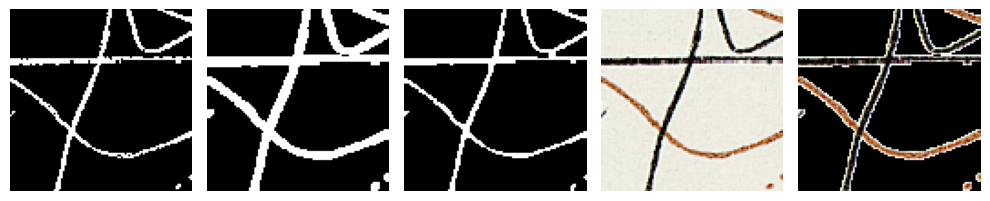

In [104]:
kernel_1 = np.ones((3,3),np.uint8)
kernel_2 = np.ones((3,3),np.uint8)
thresh_B_invert = 255 - thresh_B
B_dilation = cv2.dilate(thresh_B_invert,kernel_2,iterations = 1)
B_errosion = cv2.erode(B_dilation,kernel_1,iterations = 1)

# Use the mask on each channel (R, G, B) of the cropped image
masked_image = cv2.bitwise_and(cropped_image, cropped_image, mask=B_dilation)


plot_images(thresh_B_invert, B_dilation, B_errosion,cropped_image, masked_image)    

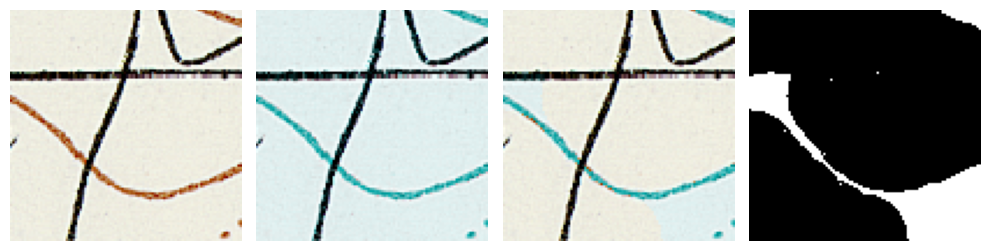

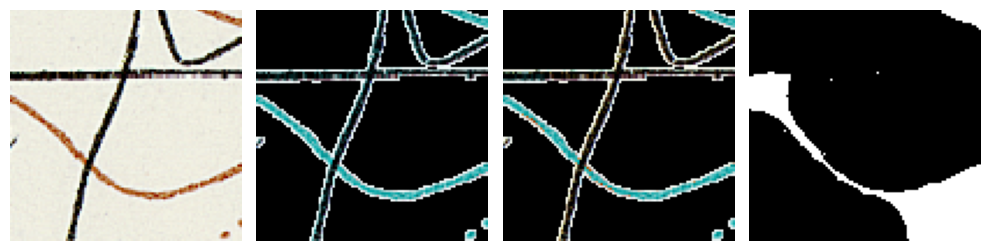

In [106]:
img_hsv, img_hsv_copy, mask_hue_05 = mask_flood_fill(cropped_image, seed=(58, 24), tolerance=0.5)

plot_images(cropped_image,color.hsv2rgb(img_hsv), color.hsv2rgb(img_hsv_copy), mask_hue_05)


img1, img2, mask3 = mask_flood_fill(masked_image, seed=(58, 24), tolerance=0.5)

plot_images(cropped_image,color.hsv2rgb(img1), color.hsv2rgb(img2), mask3)
